In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat.textstat import *
import re
import nltk
nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\1408\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.WordNetLemmatizer()

In [28]:
type_of_content = "filtered"

df_consp = pd.read_csv(f'./data/preprocessed/conspiracy_preprocessed_filtered.csv')

df_consp['title'] = df_consp['title'].apply(str) 
df_consp['selftext'] = df_consp['selftext'].apply(str) 
df_consp.loc[df_consp['title'].isin({ "remove", "delete", "nan"}),'title'] = ""
df_consp.loc[df_consp['selftext'].isin({ "remove", "delete", "nan"}),'selftext'] = ""
df_consp['wholetext'] = df_consp['title'] + " " + df_consp['selftext']

df_consp['label'] = 0
df_consp.shape

(3616, 83)

In [38]:
subreddit_control = "ukraine"
df_control = pd.read_csv(f'./data/ukraine_subsampling.csv')

df_control['title'] = df_control['title'].apply(str) 
df_control['selftext'] = df_control['selftext'].apply(str) 
df_control.loc[df_control['title'].isin({ "remove", "delete", "nan"}),'title'] = ""
df_control.loc[df_control['selftext'].isin({ "remove", "delete", "nan"}),'selftext'] = ""
df_control['wholetext'] = df_control['title'] + " " + df_control['selftext']

df_control['label'] = 1
df = pd.concat([df_consp, df_control], axis=0)
df_control.shape

(5362, 91)

In [39]:
submissions = df.wholetext.apply(str)

In [6]:
def preprocessing(text):
    text = str(text)
    text = text.lower()
    return re.sub(r"(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|^&gt;","",text)

def tokenize(text):
    text = re.sub(r"[^0-9A-Za-z' \t]","",text)
    text = tokenizer.tokenize(text)
    text = [lemmatizer.lemmatize(word, pos="v") for word in text]
    return text



In [24]:
#tfidf_vectorizer = TfidfVectorizer(
 #           stop_words=nltk.corpus.stopwords.words('english'),
  #          ngram_range=(1,2),
   #         min_df=5)


In [40]:
SentimentAnalyzer = SentimentIntensityAnalyzer()
from textblob import TextBlob

def getSentiments(submissions):
    sentiments = []
    for submission in submissions:
        sentiment = SentimentAnalyzer.polarity_scores(submission)
        sentiment_blob = TextBlob(submission).polarity
        sentiments.append([sentiment['pos'], sentiment['neg'], sentiment['neu'], sentiment['compound'], sentiment_blob])
    return sentiments



In [18]:
reddit_features = df[['num_comments', 'score']].to_numpy()
reddit_features

array([[13,  1],
       [ 0,  1],
       [44,  1],
       ...,
       [ 1,  1],
       [ 1,  1],
       [ 1,  1]], dtype=int64)

In [10]:
#features = np.concatenate([tfidf, sentiments], axis=1)
#features = np.concatenate([tfidf, sentiments], axis=1)

#features.shape

(8978, 3553)

In [41]:
#X = pd.DataFrame(features)
df['wholetext'] = df['wholetext'].apply(str)
X = df['wholetext']
y = df['label']

In [46]:
import eli5
from sklearn.pipeline import Pipeline
pd.set_option('display.max_rows', None)

tfidf_vectorizer = TfidfVectorizer( ngram_range=(1, 2), max_features=150000)
#evtl stratify?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
#X_train_text = np.concatenate([tfidf_vectorizer.fit_transform(X_train).toarray()], getSentiments(X_train)], axis=1)
X_train_text = np.concatenate([tfidf_vectorizer.fit_transform(X_train).toarray()], axis=1)
model = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
model.fit(X_train_text, y_train)
#eli5.show_weights(estimator=model, feature_names=list(tfidf_vectorizer.get_feature_names_out()) + ["pos", "neg", "neu", "com", "blob"], top=(10, 5))
eli5.show_weights(estimator=model, feature_names=list(tfidf_vectorizer.get_feature_names_out()), top=(10, 5))


Weight?,Feature
+5.241,to
+4.416,help
+3.625,ukrainian
+3.588,russian
+3.499,can
+2.731,please
+2.505,my
+2.319,hope
+2.288,send
+2.236,if


In [48]:
#class_weight penalty='l2' multi_class='ovr', , C=0.01
#X_test_text = tfidf_vectorizer.transform(X_test)
#X_test_text = np.concatenate([tfidf_vectorizer.transform(X_test).toarray(), getSentiments(X_test)], axis=1)
X_test_text = np.concatenate([tfidf_vectorizer.transform(X_test).toarray()], axis=1)
y_predict = model.predict(X_test_text)
rep = classification_report(y_test, y_predict)

print(rep)

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1087
           1       0.88      0.88      0.88      1607

    accuracy                           0.86      2694
   macro avg       0.85      0.85      0.85      2694
weighted avg       0.86      0.86      0.86      2694



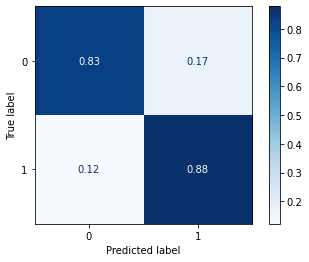

In [49]:
conf_matrix = confusion_matrix(y_test, y_predict, normalize='true')
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot(cmap='Blues')
plt.savefig(f"./images/model/{subreddit_control}_{type_of_content}.png")

results 93 83 mit pushshift